# Punishment Study 2.1.2 - NLP Analysis

**Goal**: Analyze open-ended punishment justifications to detect the 'prosocial facade'

**Setup**: Runtime > Change runtime type > GPU (T4)

In [ ]:
# SECTION 0: INSTALL PACKAGES
!pip install -q transformers sentence-transformers bertopic umap-learn hdbscan
!pip install -q vaderSentiment empath wordcloud nrclex
!pip install -q plotly kaleido tqdm
print('Installation complete!')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.6 MB/s eta 0:00:00
Installation complete!


In [ ]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from empath import Empath
from nrclex import NRCLex
from wordcloud import WordCloud
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
import umap
from scipy import stats
from scipy.stats import pearsonr
from tqdm import tqdm
from google.colab import files

print('Imports complete!')

Imports complete!


In [ ]:
# UPLOAD DATA
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
print(f'Loaded {len(df)} rows')

Saving punishment_212_cleaned_data.csv to punishment_212_cleaned_data.csv
Loaded 496 rows


In [ ]:
# SECTION 1: TEXT PREPROCESSING
def clean_text(text):
    if pd.isna(text) or text == '':
        return ''
    text = str(text).lower()
    text = ' '.join(text.split())
    text = re.sub(r'[^a-z0-9\s\.\,\!\?\'\-]', '', text)
    return text.strip()

df['text1_clean'] = df['Sentence_OpenEnd1'].apply(clean_text)
df['text2_clean'] = df['Sentence_OpenEnd2'].apply(clean_text)
df['text_combined'] = df.apply(lambda r: f"{r['text1_clean']} {r['text2_clean']}".strip(), axis=1)

df['text1_wordcount'] = df['text1_clean'].apply(lambda x: len(x.split()) if x else 0)
df['text2_wordcount'] = df['text2_clean'].apply(lambda x: len(x.split()) if x else 0)
df['text_combined_wordcount'] = df['text1_wordcount'] + df['text2_wordcount']

df_valid = df[df['text_combined_wordcount'] >= 3].copy()
print(f'Valid responses: {len(df_valid)} of {len(df)}')
print(f'Mean word count Q1: {df_valid["text1_wordcount"].mean():.1f}')
print(f'Mean word count Q2: {df_valid["text2_wordcount"].mean():.1f}')

Valid responses: 496 of 496
Mean word count Q1: 28.8
Mean word count Q2: 19.5


In [ ]:
# Sample responses
print('=== SAMPLE RESPONSES ===')
for i in range(3):
    print(f'\n--- {i+1} ---')
    print(f"Q1: {df_valid['Sentence_OpenEnd1'].iloc[i]}")
    print(f"Q2: {df_valid['Sentence_OpenEnd2'].iloc[i]}")

=== SAMPLE RESPONSES ===

--- 1 ---
Q1: This was a violent robbery that escalated into a fatal attack
Q2: accountability and rehabilitation 

--- 2 ---
Q1: he deserves jailtime
Q2: rehabilitate and remind

--- 3 ---
Q1: Darryl killed a completely innocent woman, and a stranger, for no reason at all, and in my opinion has forfeit any right to freedom or a normal life because of this.
Q2: Removal of a dangerous and deranged person from society where he cannot harm anyone else.


In [ ]:
# SECTION 2: VADER SENTIMENT
vader = SentimentIntensityAnalyzer()

def get_vader(text):
    if not text: return {'neg': np.nan, 'neu': np.nan, 'pos': np.nan, 'compound': np.nan}
    return vader.polarity_scores(text)

print('Computing VADER scores...')
vader_1 = df_valid['text1_clean'].apply(get_vader).apply(pd.Series)
vader_1.columns = ['vader1_neg', 'vader1_neu', 'vader1_pos', 'vader1_compound']
vader_2 = df_valid['text2_clean'].apply(get_vader).apply(pd.Series)
vader_2.columns = ['vader2_neg', 'vader2_neu', 'vader2_pos', 'vader2_compound']
vader_c = df_valid['text_combined'].apply(get_vader).apply(pd.Series)
vader_c.columns = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

df_valid = pd.concat([df_valid, vader_1, vader_2, vader_c], axis=1)
print(f'Mean compound sentiment: {df_valid["vader_compound"].mean():.3f}')

Computing VADER scores...
Mean compound sentiment: -0.501


In [ ]:
# SECTION 2B: EMPATH CATEGORIES
lexicon = Empath()
empath_cats = ['violence', 'crime', 'death', 'pain', 'suffering', 'negative_emotion', 'positive_emotion',
               'anger', 'fear', 'hate', 'disgust', 'sympathy', 'help', 'government', 'law', 'order', 'power',
               'family', 'children', 'healing', 'prison', 'weapon', 'fight', 'kill', 'trust', 'achievement']

def get_empath(text):
    if not text: return {c: 0 for c in empath_cats}
    scores = lexicon.analyze(text, categories=empath_cats, normalize=True)
    return scores if scores else {c: 0 for c in empath_cats}

print('Computing Empath scores...')
empath_df = df_valid['text_combined'].apply(get_empath).apply(pd.Series)
empath_df.columns = ['empath_' + c for c in empath_df.columns]
df_valid = pd.concat([df_valid, empath_df.fillna(0)], axis=1)
print('Empath complete!')

Computing Empath scores...
Empath complete!


In [ ]:
# SECTION 2C: CUSTOM JUSTIFICATION DICTIONARY
punishment_dict = {
    'deterrence': ['deter', 'prevent', 'discourage', 'warning', 'example', 'lesson', 'think twice', 'stop others'],
    'incapacitation': ['protect', 'safety', 'safe', 'remove', 'dangerous', 'threat', 'public', 'keep away', 'off the streets'],
    'rehabilitation': ['rehabilitate', 'reform', 'change', 'learn', 'treatment', 'therapy', 'help', 'improve', 'better person', 'second chance', 'program', 'education'],
    'retribution': ['deserve', 'fair', 'just', 'justice', 'proportional', 'appropriate', 'consequences', 'accountable', 'responsible', 'pay for'],
    'norm_expression': ['wrong', 'unacceptable', 'society', 'values', 'moral', 'message', 'condemn', 'show', 'signal'],
    'revenge': ['revenge', 'vengeance', 'payback', 'get back', 'retaliate', 'eye for', 'taste of'],
    'suffering': ['suffer', 'pain', 'hurt', 'agony', 'torment', 'misery', 'feel what', 'rot'],
    'degradation': ['humiliate', 'shame', 'disgrace', 'worthless', 'scum', 'animal', 'monster'],
    'exclusion': ['remove', 'rid', 'eliminate', 'banish', 'no place', 'throw away', 'lock up forever'],
    'victim_focus': ['victim', 'family', 'closure', 'peace', 'loved ones']
}

def count_dict_words(text, word_dict):
    if not text: return {k: 0 for k in word_dict}
    text_lower = text.lower()
    words = text_lower.split()
    wc = len(words) if words else 1
    scores = {}
    for cat, wordlist in word_dict.items():
        count = sum(1 for w in words if any(w.startswith(term) for term in wordlist if ' ' not in term))
        count += sum(text_lower.count(term) for term in wordlist if ' ' in term)
        scores[cat] = count / wc
    return scores

print('Computing custom dictionary scores...')
just_df = df_valid['text_combined'].apply(lambda x: count_dict_words(x, punishment_dict)).apply(pd.Series)
just_df.columns = ['just_' + c for c in just_df.columns]
df_valid = pd.concat([df_valid, just_df], axis=1)

# Aggregates
prosocial = ['just_deterrence', 'just_incapacitation', 'just_rehabilitation', 'just_retribution', 'just_norm_expression']
dark = ['just_revenge', 'just_suffering', 'just_degradation', 'just_exclusion']
df_valid['just_prosocial'] = df_valid[prosocial].sum(axis=1)
df_valid['just_dark'] = df_valid[dark].sum(axis=1)
df_valid['just_prosocial_minus_dark'] = df_valid['just_prosocial'] - df_valid['just_dark']
print('Dictionary analysis complete!')

Computing custom dictionary scores...
Dictionary analysis complete!


In [ ]:
# SECTION 3: ZERO-SHOT CLASSIFICATION
print('Loading zero-shot model...')
classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli', device=0)

labels = [
    'deterrence and prevention', 'public safety and protection', 'rehabilitation and reform',
    'proportional justice', 'revenge and payback', 'punishment and suffering',
    'victim closure', 'societal condemnation'
]

def classify_text(text):
    if not text or len(text.split()) < 3:
        return {l: np.nan for l in labels}
    try:
        result = classifier(text[:512], labels, multi_label=True)
        return dict(zip(result['labels'], result['scores']))
    except:
        return {l: np.nan for l in labels}

print('Running zero-shot classification')
zs_results = []
for text in tqdm(df_valid['text_combined'].tolist()):
    zs_results.append(classify_text(text))

zs_df = pd.DataFrame(zs_results)
zs_df.columns = ['zs_' + c.replace(' ', '_') for c in zs_df.columns]
zs_df.index = df_valid.index
df_valid = pd.concat([df_valid, zs_df], axis=1)

# Aggregates
zs_prosocial = [c for c in zs_df.columns if any(x in c for x in ['deterrence', 'safety', 'rehabilitation', 'justice'])]
zs_dark = [c for c in zs_df.columns if any(x in c for x in ['revenge', 'suffering'])]
if zs_prosocial: df_valid['zs_prosocial_mean'] = df_valid[zs_prosocial].mean(axis=1)
if zs_dark: df_valid['zs_dark_mean'] = df_valid[zs_dark].mean(axis=1)
if zs_prosocial and zs_dark: df_valid['zs_prosocial_minus_dark'] = df_valid['zs_prosocial_mean'] - df_valid['zs_dark_mean']
print('Zero-shot complete!')

Loading zero-shot model...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


Running zero-shot classification (may take 5-10 minutes)...


100%|██████████| 496/496 [02:16<00:00,  3.64it/s]

Zero-shot complete!


In [ ]:
# SECTION 4: EMBEDDINGS
print('Loading embedding model (all-mpnet-base-v2)...')
embedding_model = SentenceTransformer('all-mpnet-base-v2')

print('Generating embeddings...')
texts = [t if t else 'no response' for t in df_valid['text_combined'].tolist()]
embeddings = embedding_model.encode(texts, show_progress_bar=True, batch_size=32)
print(f'Embeddings shape: {embeddings.shape}')

Loading embedding model (all-mpnet-base-v2)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings...


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Embeddings shape: (496, 768)


In [ ]:
# SECTION 4B: PROTOTYPE SENTENCES
prototypes = {
    'proto_deterrence': [
        'This sentence will deter others from committing similar crimes.',
        'Punishment sends a message that crime does not pay.',
        'This will make others think twice before breaking the law.'
    ],
    'proto_incapacitation': [
        'This keeps dangerous criminals away from society.',
        'The public needs to be protected from this offender.',
        'Society is safer with this person behind bars.'
    ],
    'proto_rehabilitation': [
        'Time in prison gives the offender a chance to reform.',
        'With proper programs, this person can become a productive member of society.',
        'Everyone deserves a second chance to become a better person.'
    ],
    'proto_retribution': [
        'This sentence is proportional to the severity of the crime.',
        'Justice requires that wrongdoers face appropriate consequences.',
        'The offender deserves this punishment for their actions.'
    ],
    'proto_revenge': [
        'He deserves to suffer for what he did.',
        'This is payback for the harm he caused.',
        'An eye for an eye - he should feel the same pain.'
    ],
    'proto_suffering': [
        'I want him to suffer in prison.',
        'Prison should be painful and miserable.',
        'Let him rot and suffer behind bars.'
    ],
    'proto_exclusion': [
        'He has no place in our society.',
        'Lock him up and throw away the key.',
        'He forfeited his right to be part of society.'
    ]
}

print('Computing prototype embeddings...')
proto_embeddings = {}
for cat, sents in prototypes.items():
    emb = embedding_model.encode(sents)
    proto_embeddings[cat] = np.mean(emb, axis=0)

print('Computing similarity to prototypes...')
for cat, proto_emb in proto_embeddings.items():
    sims = cosine_similarity(embeddings, proto_emb.reshape(1, -1)).flatten()
    df_valid[f'sim_{cat}'] = sims

# Aggregates
prosocial_sim = ['sim_proto_deterrence', 'sim_proto_incapacitation', 'sim_proto_rehabilitation', 'sim_proto_retribution']
dark_sim = ['sim_proto_revenge', 'sim_proto_suffering', 'sim_proto_exclusion']
df_valid['sim_prosocial_mean'] = df_valid[prosocial_sim].mean(axis=1)
df_valid['sim_dark_mean'] = df_valid[dark_sim].mean(axis=1)
df_valid['sim_prosocial_minus_dark'] = df_valid['sim_prosocial_mean'] - df_valid['sim_dark_mean']
print('Similarity complete!')

Computing prototype embeddings...
Computing similarity to prototypes...
Similarity complete!


In [ ]:
# SECTION 4C: UMAP & CLUSTERING
print('Running UMAP...')
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', random_state=42)
embed_2d = reducer.fit_transform(embeddings)
df_valid['umap_x'] = embed_2d[:, 0]
df_valid['umap_y'] = embed_2d[:, 1]

print('Running K-means...')
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_valid['cluster'] = kmeans.fit_predict(embeddings)
print(f'Cluster distribution:\n{df_valid["cluster"].value_counts().sort_index()}')

Running UMAP...
Running K-means...
Cluster distribution:
cluster
0    140
1     75
2    133
3     58
4     90
Name: count, dtype: int64


In [ ]:
# SECTION 4D: BERTOPIC
print('Running BERTopic...')
topic_model = BERTopic(embedding_model=embedding_model, nr_topics='auto', min_topic_size=15, verbose=True)
topics, probs = topic_model.fit_transform(texts, embeddings)
df_valid['bertopic_topic'] = topics

print('\nBERTopic Results:')
print(topic_model.get_topic_info().head(10))

# Save topic info
topic_model.get_topic_info().to_csv('bertopic_topics.csv', index=False)
print('Saved: bertopic_topics.csv')

2026-01-15 22:54:29,733 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Running BERTopic...


2026-01-15 22:54:39,685 - BERTopic - Dimensionality - Completed ✓
2026-01-15 22:54:39,703 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-15 22:54:39,799 - BERTopic - Cluster - Completed ✓
2026-01-15 22:54:39,805 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2026-01-15 22:54:39,910 - BERTopic - Representation - Completed ✓
2026-01-15 22:54:39,914 - BERTopic - Topic reduction - Reducing number of topics
2026-01-15 22:54:39,941 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-15 22:54:40,054 - BERTopic - Representation - Completed ✓
2026-01-15 22:54:40,060 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3



BERTopic Results:
   Topic  Count                 Name  \
0      0    262      0_he_to_the_and   
1      1    212  1_the_to_and_darryl   
2      2     22  2_he_frankie_to_and   

                                      Representation  \
0    [he, to, the, and, it, of, him, for, that, his]   
1  [the, to, and, darryl, of, he, that, for, sent...   
2  [he, frankie, to, and, the, for, him, was, it,...   

                                 Representative_Docs  
0  [because he brutally beat and killed a man. he...  
1  [i recommended this sentence for darryl becaus...  
2  [i think that he did not intend to kill franki...  
Saved: bertopic_topics.csv


In [ ]:
# SECTION 5: FACADE DETECTION
print('=' * 70)
print('FACADE DETECTION ANALYSIS')
print('=' * 70)

psych_vars = ['punitiveness_agg', 'hostile_agg', 'hatred_comp', 'revenge_comp', 'sdo_comp', 'raceresent_comp', 'crime_concerns_agg']
text_vars = ['sim_prosocial_mean', 'sim_dark_mean', 'sim_prosocial_minus_dark', 'just_prosocial', 'just_dark', 'vader_compound']

psych_vars = [v for v in psych_vars if v in df_valid.columns]
text_vars = [v for v in text_vars if v in df_valid.columns]

print('\nKey Facade Detection Correlations:')
print('-' * 60)
for tv in text_vars:
    for pv in psych_vars:
        mask = df_valid[[tv, pv]].notna().all(axis=1)
        if mask.sum() > 30:
            r, p = pearsonr(df_valid.loc[mask, tv], df_valid.loc[mask, pv])
            if p < 0.05:
                sig = '***' if p < .001 else '**' if p < .01 else '*'
                print(f'{tv:30} x {pv:20}: r={r:6.3f}, p={p:.4f} {sig}')

FACADE DETECTION ANALYSIS

Key Facade Detection Correlations:
------------------------------------------------------------
sim_prosocial_mean             x punitiveness_agg    : r=-0.127, p=0.0047 **
sim_prosocial_minus_dark       x punitiveness_agg    : r=-0.172, p=0.0001 ***
sim_prosocial_minus_dark       x revenge_comp        : r=-0.091, p=0.0421 *
just_prosocial                 x punitiveness_agg    : r=-0.100, p=0.0260 *
just_prosocial                 x crime_concerns_agg  : r=-0.112, p=0.0129 *
just_dark                      x punitiveness_agg    : r= 0.126, p=0.0050 **
just_dark                      x revenge_comp        : r= 0.095, p=0.0349 *
vader_compound                 x punitiveness_agg    : r=-0.193, p=0.0000 ***
vader_compound                 x hatred_comp         : r=-0.091, p=0.0421 *


In [ ]:
# SECTION 5B: FACADE MISMATCH SCORE
if 'sim_prosocial_mean' in df_valid.columns and 'hostile_agg' in df_valid.columns:
    mask = df_valid[['sim_prosocial_mean', 'hostile_agg']].notna().all(axis=1)
    X = df_valid.loc[mask, 'hostile_agg'].values.reshape(-1, 1)
    y = df_valid.loc[mask, 'sim_prosocial_mean'].values
    reg = LinearRegression().fit(X, y)
    df_valid.loc[mask, 'facade_residual'] = y - reg.predict(X)

    print('\nFacade Residual Score (positive = more prosocial than expected):')
    print(df_valid['facade_residual'].describe())


Facade Residual Score (positive = more prosocial than expected):
count    4.960000e+02
mean     2.238353e-18
std      8.037737e-02
min     -3.414643e-01
25%     -3.998458e-02
50%      1.289358e-02
75%      5.380243e-02
max      2.493469e-01
Name: facade_residual, dtype: float64


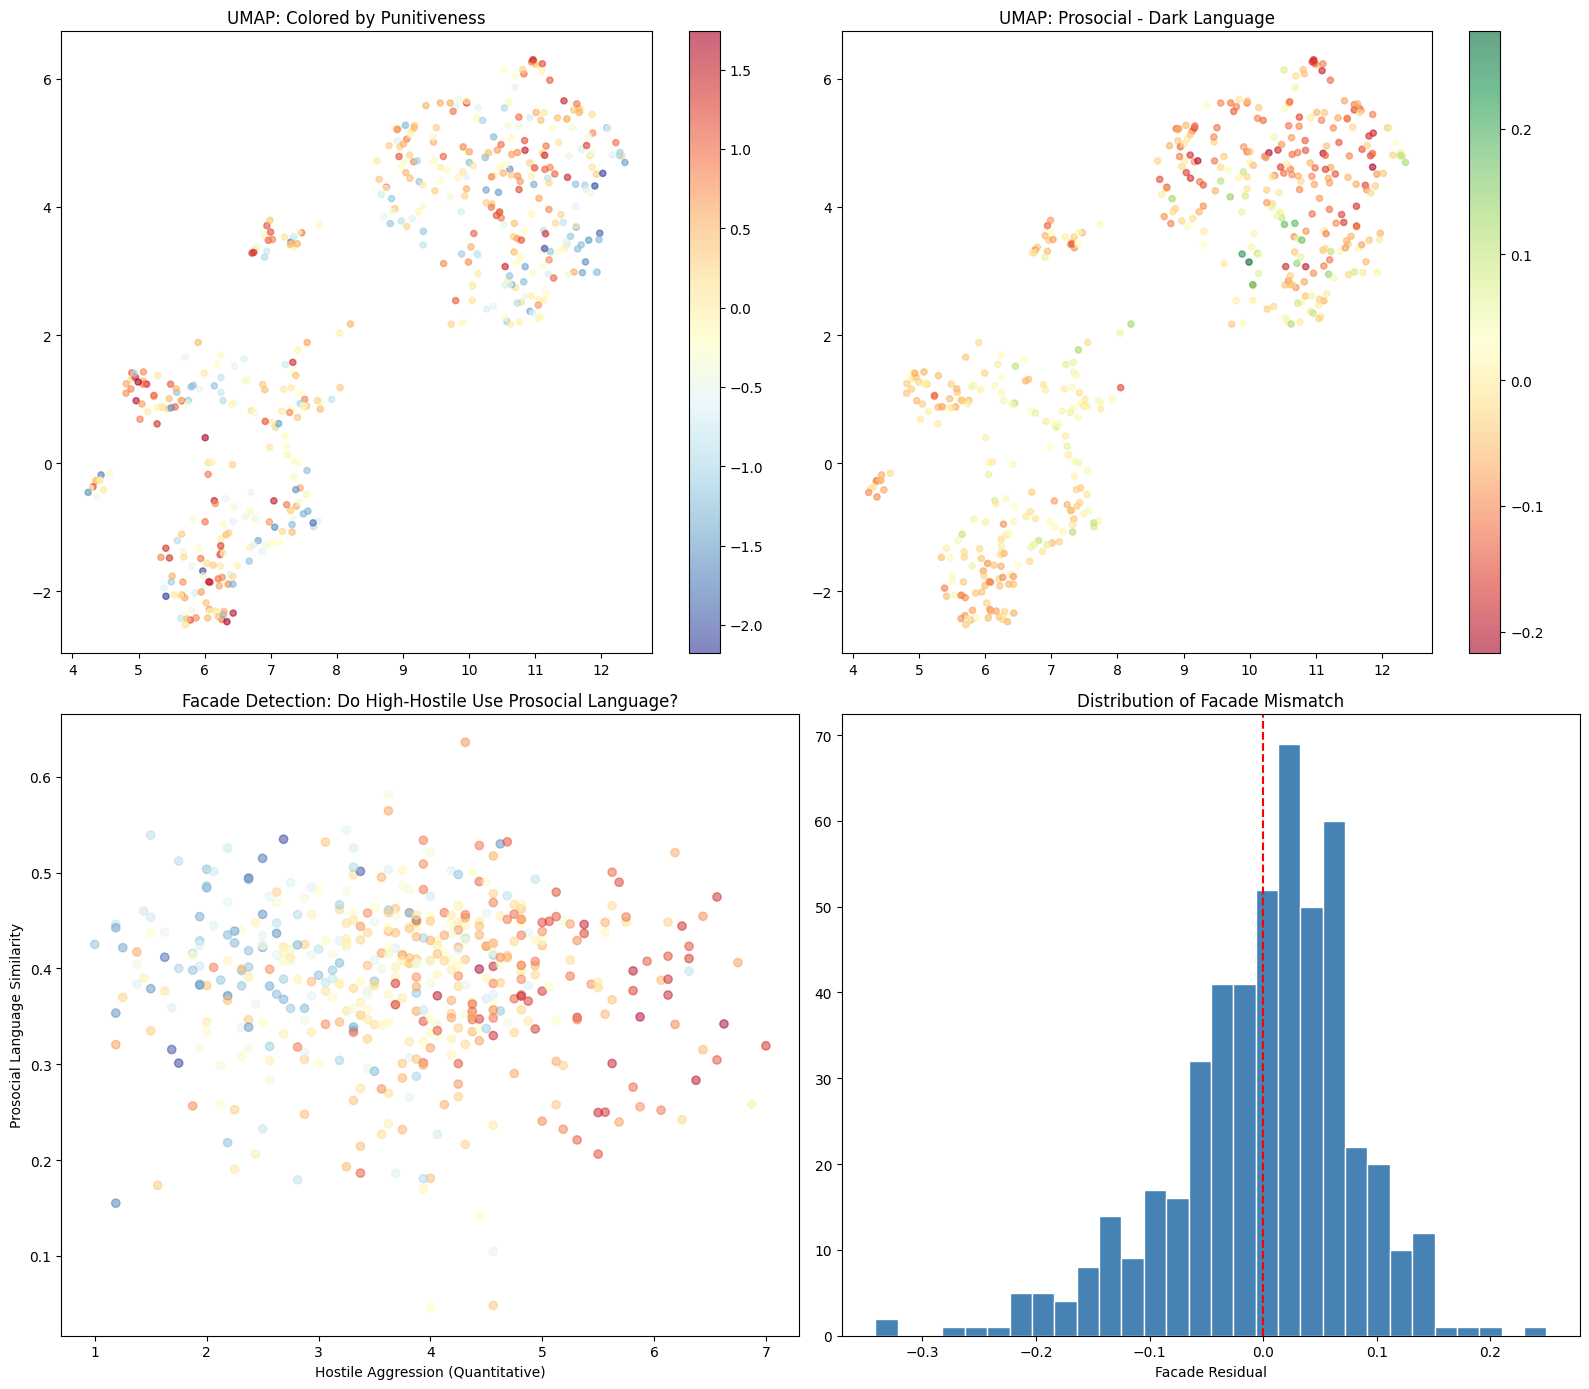

Saved: facade_visualizations.png


In [ ]:
# SECTION 6: VISUALIZATIONS
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# UMAP by punitiveness
sc1 = axes[0,0].scatter(df_valid['umap_x'], df_valid['umap_y'], c=df_valid['punitiveness_agg'], cmap='RdYlBu_r', alpha=0.6, s=20)
axes[0,0].set_title('UMAP: Colored by Punitiveness')
plt.colorbar(sc1, ax=axes[0,0])

# UMAP by prosocial-dark diff
sc2 = axes[0,1].scatter(df_valid['umap_x'], df_valid['umap_y'], c=df_valid['sim_prosocial_minus_dark'], cmap='RdYlGn', alpha=0.6, s=20)
axes[0,1].set_title('UMAP: Prosocial - Dark Language')
plt.colorbar(sc2, ax=axes[0,1])

# Hostile vs Prosocial Language
axes[1,0].scatter(df_valid['hostile_agg'], df_valid['sim_prosocial_mean'], c=df_valid['punitiveness_agg'], cmap='RdYlBu_r', alpha=0.5)
axes[1,0].set_xlabel('Hostile Aggression (Quantitative)')
axes[1,0].set_ylabel('Prosocial Language Similarity')
axes[1,0].set_title('Facade Detection: Do High-Hostile Use Prosocial Language?')

# Facade residual distribution
if 'facade_residual' in df_valid.columns:
    axes[1,1].hist(df_valid['facade_residual'].dropna(), bins=30, color='steelblue', edgecolor='white')
    axes[1,1].axvline(0, color='red', linestyle='--')
    axes[1,1].set_xlabel('Facade Residual')
    axes[1,1].set_title('Distribution of Facade Mismatch')

plt.tight_layout()
plt.savefig('facade_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: facade_visualizations.png')

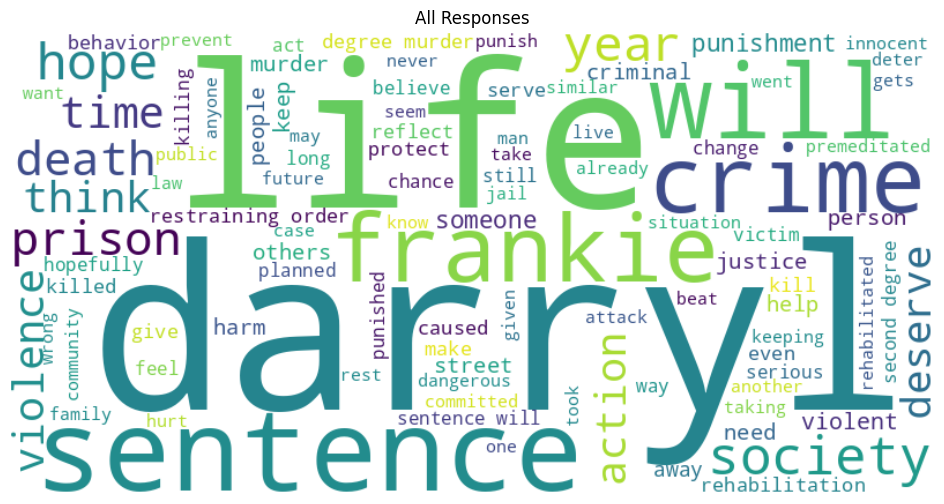

Saved: wordcloud_all.png


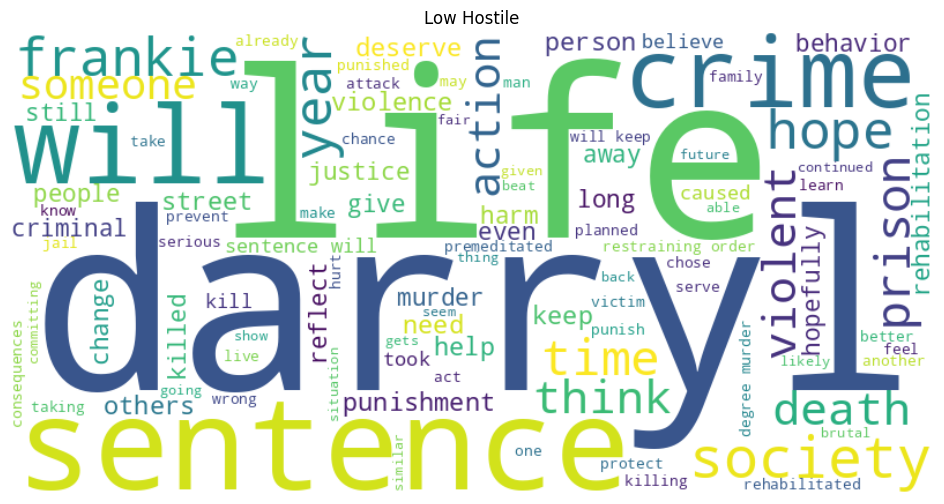

Saved: wordcloud_low_hostile.png


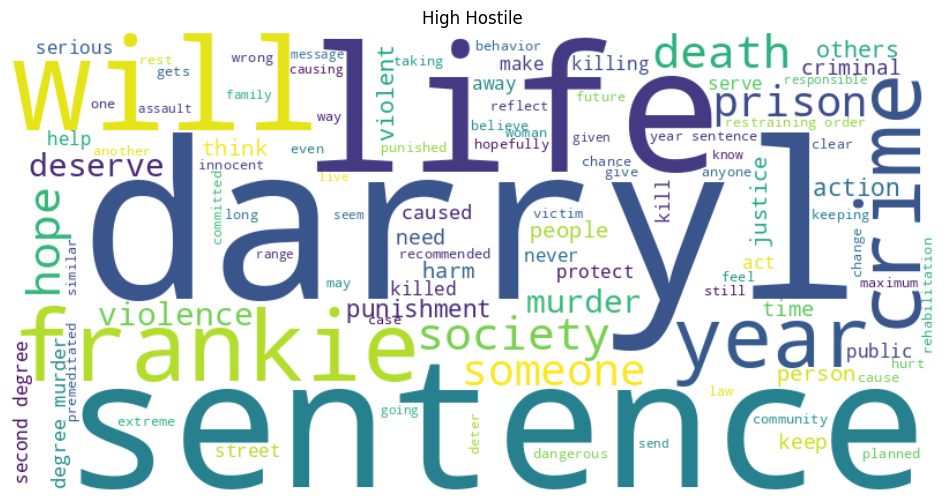

Saved: wordcloud_high_hostile.png


In [ ]:
# WORD CLOUDS
def make_wordcloud(texts, title, fname):
    text = ' '.join([t for t in texts if t])
    wc = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {fname}')

make_wordcloud(df_valid['text_combined'].tolist(), 'All Responses', 'wordcloud_all.png')

if 'hostile_agg' in df_valid.columns:
    med = df_valid['hostile_agg'].median()
    make_wordcloud(df_valid[df_valid['hostile_agg'] <= med]['text_combined'].tolist(), 'Low Hostile', 'wordcloud_low_hostile.png')
    make_wordcloud(df_valid[df_valid['hostile_agg'] > med]['text_combined'].tolist(), 'High Hostile', 'wordcloud_high_hostile.png')

In [ ]:
# SECTION 7: EXPORT
print('\n' + '=' * 70)
print('EXPORTING RESULTS')
print('=' * 70)

df_valid.to_csv('punishment_212_nlp_features.csv', index=False)
print('Saved: punishment_212_nlp_features.csv')

# Correlation matrix
psych = [v for v in ['punitiveness_agg', 'hostile_agg', 'hatred_comp', 'revenge_comp', 'sdo_comp'] if v in df_valid.columns]
text = [v for v in ['sim_prosocial_mean', 'sim_dark_mean', 'just_prosocial', 'just_dark', 'vader_compound'] if v in df_valid.columns]

corr_matrix = pd.DataFrame(index=text, columns=psych)
for t in text:
    for p in psych:
        mask = df_valid[[t, p]].notna().all(axis=1)
        if mask.sum() > 30:
            r, _ = pearsonr(df_valid.loc[mask, t], df_valid.loc[mask, p])
            corr_matrix.loc[t, p] = r

corr_matrix.to_csv('facade_correlation_matrix.csv')
print('Saved: facade_correlation_matrix.csv')


EXPORTING RESULTS
Saved: punishment_212_nlp_features.csv
Saved: facade_correlation_matrix.csv


In [ ]:
# SUMMARY
print('\n' + '=' * 70)
print('SUMMARY')
print('=' * 70)
print(f'Responses analyzed: {len(df_valid)}')
print(f'Mean word count: {df_valid["text_combined_wordcount"].mean():.1f}')
print(f'Mean sentiment: {df_valid["vader_compound"].mean():.3f}')
if 'sim_prosocial_mean' in df_valid.columns and 'hostile_agg' in df_valid.columns:
    r, p = pearsonr(df_valid['sim_prosocial_mean'].dropna(), df_valid.loc[df_valid['sim_prosocial_mean'].notna(), 'hostile_agg'])
    print(f'\nKEY FINDING - Prosocial Language x Hostile Aggression: r={r:.3f}, p={p:.4f}')
    if r > 0.05: print('INTERPRETATION: People high on hostile aggression use MORE prosocial language (facade detected)')
    elif r < -0.05: print('INTERPRETATION: People high on hostile aggression use LESS prosocial language (no facade)')
    else: print('INTERPRETATION: No relationship between hostile aggression and prosocial language')

print('\n' + '=' * 70)
print('ANALYSIS COMPLETE')
print('=' * 70)


SUMMARY
Responses analyzed: 496
Mean word count: 48.3
Mean sentiment: -0.501

KEY FINDING - Prosocial Language x Hostile Aggression: r=-0.042, p=0.3536
INTERPRETATION: No relationship between hostile aggression and prosocial language

ANALYSIS COMPLETE


In [ ]:
# DOWNLOAD FILES
import os
output_files = [f for f in os.listdir('.') if f.endswith('.csv') or f.endswith('.png')]
print('Files to download:')
for f in output_files:
    print(f'  - {f}')

for f in output_files:
    try:
        files.download(f)
    except:
        print(f'Please manually download: {f}')

Files to download:
  - facade_visualizations.png
  - wordcloud_high_hostile.png
  - facade_correlation_matrix.csv
  - wordcloud_all.png
  - punishment_212_cleaned_data.csv
  - wordcloud_low_hostile.png
  - punishment_212_nlp_features.csv
  - bertopic_topics.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>